# Moving Average
This strategy does not look at the current price but instead at the moving average of the price pa. We will consider different time intervals for calculating the moving average: two hours, six hours, one day, seven days, 30 days, 100 days, and 200 days. The liquidity position of this strategy will be [pa − a, pa + a]. As in the constant interval strategy 4.3, the leftover token will not be used to provide any liquidity.

In [2]:
import math
import pandas as pd
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

import matplotlib.pyplot as plt
from datetime import date, timedelta
from decimal import Decimal
from demeter import TokenInfo, Actuator, Strategy, ChainType, MarketInfo, PeriodTrigger, simple_moving_average
from demeter.result import performance_metrics, round_results
from demeter.uniswap import UniV3Pool, UniLpMarket
from demeter import Snapshot


usdc = TokenInfo(name="usdc", decimal=6)
eth = TokenInfo(name="eth", decimal=18)
pool_address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
market_key = MarketInfo("market1")
start_date = date(2025, 1, 1)
end_date = date(2025, 3, 1)

def load_market_data(market, data_path="../data"):
    market.data_path = data_path
    market.load_data(
        chain=ChainType.ethereum.name,
        contract_addr=pool_address,
        start_date=start_date,
        end_date=end_date,
    )
    return market

class MovingAverageStrategy(Strategy):
    def __init__(self, band=0.05, update_interval=timedelta(days=1)):
        super().__init__()
        self.band = band
        self.update_interval = update_interval

    def initialize(self):
        self.add_column(market_key, "sma", simple_moving_average(self.data[market_key].price, window=timedelta(days=1)))
        self.triggers.append(PeriodTrigger(time_delta=self.update_interval, trigger_immediately=True, do=self.rebalance))

    def rebalance(self, row_data: Snapshot):
        self.markets[market_key].even_rebalance(row_data.market_status[market_key].price)

    def work(self, row_data: Snapshot):
        lp_market: UniLpMarket = self.markets[market_key]
        current_price = row_data.market_status[market_key].price
        ma_price = self.data[market_key].loc[row_data.timestamp]["sma"]
        ma_price = row_data.market_status[market_key].price if math.isnan(ma_price) else ma_price


        # Rebalance liquidity
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(current_price)

        lower_bound = current_price * (1 - self.band)
        upper_bound = current_price * (1 + self.band)

        lp_market.add_liquidity(lower_bound, upper_bound)


def run_strategy(band, update_interval):
    market = load_market_data(UniLpMarket(market_key, UniV3Pool(usdc, eth, 0.05, usdc)))
    actuator = Actuator()
    actuator.broker.add_market(market)
    actuator.broker.set_balance(usdc, 5000)
    actuator.broker.set_balance(eth, 1)
    actuator.strategy = MovingAverageStrategy(band=band, update_interval=update_interval)
    actuator.set_price(market.get_price_from_data())
    actuator.run()

    # Capture and print performance metrics
    metrics = performance_metrics(
        actuator.account_status_df["net_value"], 
        benchmark=actuator.account_status_df["price"]["ETH"]
    )
    print(f"\nPerformance for band = band, Update Interval = {update_interval}:")
    print(round_results(metrics))
    
    # Return net value time series for plotting
    return actuator.account_status_df["net_value"]



2025-03-12 06:43:55,106 - INFO - Uni data - Load data from cache
2025-03-12 06:43:55,284 - INFO - Actuator - Quote token is USDC
2025-03-12 06:43:55,285 - INFO - Actuator - init strategy...
2025-03-12 06:43:55,345 - INFO - Actuator - start main loop...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [00:39<00:00, 2165.38it/s]
2025-03-12 06:44:35,251 - INFO - Actuator - main loop finished
2025-03-12 06:44:37,325 - INFO - Actuator - Print actuator summary


Final account status                              
Token balance in broker       
USDC      :3431.9302                ETH       :1.5619893                
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
Empty DataFrame


Quote by: USDC
Account balance history                           


2025-03-12 06:44:37,733 - INFO - Actuator - Backtest with process id: 2659240 finished, execute time 42.451s


l1                  net_value    tokens             market1                                                                                                          price     
l2                                 USDC       ETH net_value liquidity_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2025-01-01 00:00:00 8331.4799 4165.7398 1.2502608         0               0                0                 0                0                 0              0  3331.897    1
2025-01-01 00:01:00 8331.0633 4165.7398 1.2502608         0               0                0                 0                0                 0              0 3331.5638    1
2025-01-01 00:02:00 8331.4799 4165.7398 1.2502608         0               0                0                 0                0                 0              0  3331.897    1
2025-01-01 00:03:00 8333.5631 4165.7398 1.2502608         0               0                0                 0          

2025-03-12 06:44:38,473 - INFO - Uni data - Load data from cache
2025-03-12 06:44:38,608 - INFO - Actuator - Quote token is USDC
2025-03-12 06:44:38,608 - INFO - Actuator - init strategy...
2025-03-12 06:44:38,669 - INFO - Actuator - start main loop...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [00:52<00:00, 1646.18it/s]
2025-03-12 06:45:31,158 - INFO - Actuator - main loop finished
2025-03-12 06:45:33,468 - INFO - Actuator - Print actuator summary


Final account status                              
Token balance in broker       
USDC      :3445.4426                ETH       :1.5403207                
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
Empty DataFrame


Quote by: USDC
Account balance history                           


2025-03-12 06:45:33,836 - INFO - Actuator - Backtest with process id: 2659240 finished, execute time 55.230s


l1                  net_value    tokens             market1                                                                                                          price     
l2                                 USDC       ETH net_value liquidity_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2025-01-01 00:00:00 8331.4799 4165.7398 1.2502608         0               0                0                 0                0                 0              0  3331.897    1
2025-01-01 00:01:00 8331.0633 4165.7398 1.2502608         0               0                0                 0                0                 0              0 3331.5638    1
2025-01-01 00:02:00 8331.4799 4165.7398 1.2502608         0               0                0                 0                0                 0              0  3331.897    1
2025-01-01 00:03:00 8333.5631 4165.7398 1.2502608         0               0                0                 0          

/tmp/ipykernel_2659240/3521280936.py:18: UserWarning: Glyph 8 ) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jerzy/workspace/Backtesting-Uniswap-V3-Strategies/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8 ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


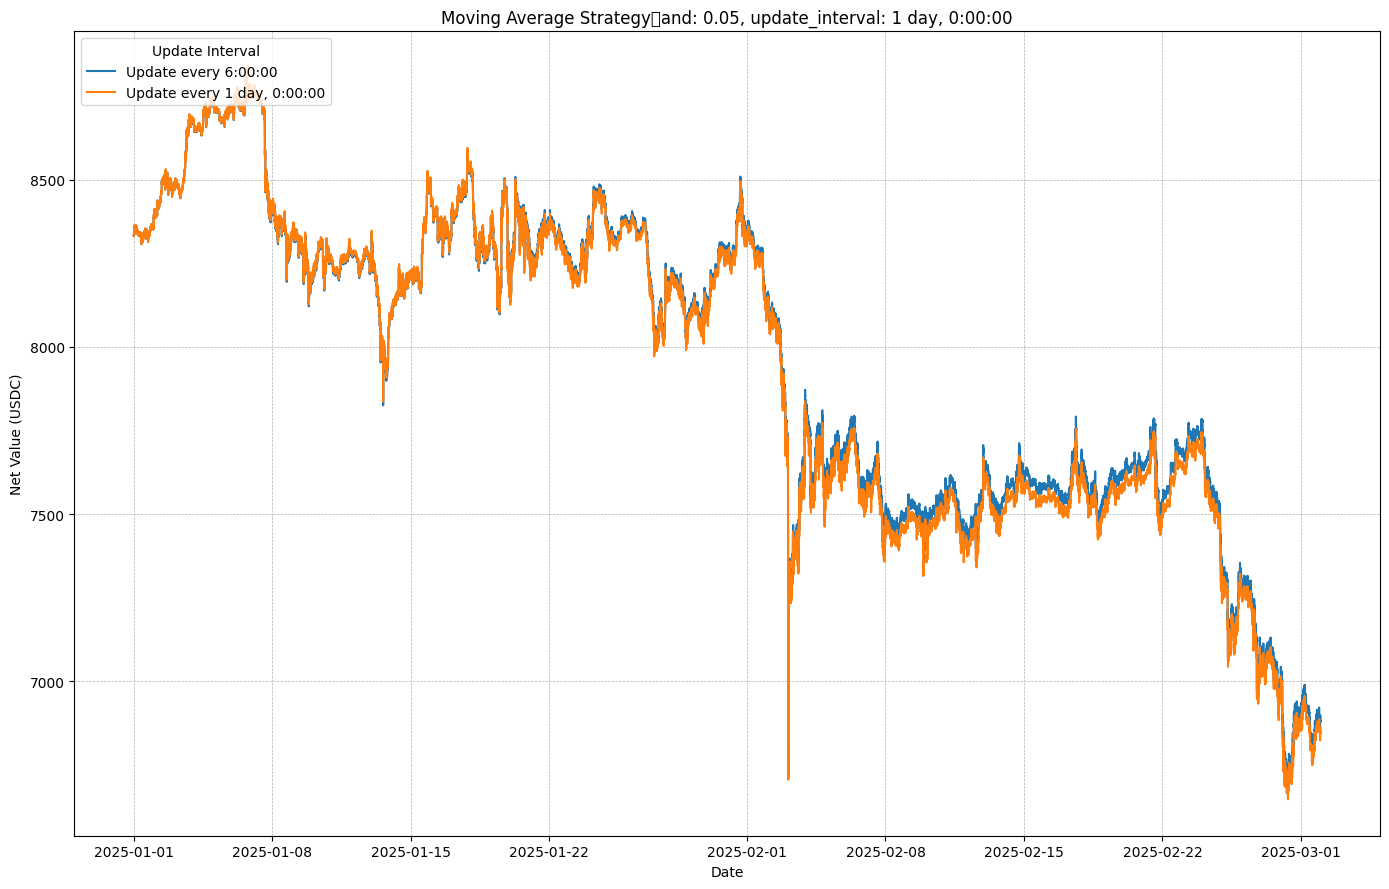

In [3]:
# Parameter sets
bands = [0.05]
update_intervals = [timedelta(hours=6), timedelta(days=1)]

# Loop through parameter combinations and plot results
for band in bands:
    plt.figure(figsize=(14, 9))
    for update_interval in update_intervals:
        net_value_series = run_strategy(band, update_interval)
        plt.plot(net_value_series.index, net_value_series, label=f"Update every {update_interval}")

    # Customize and display the plot for each threshold-liquidity range combination
    plt.title(f"Moving Average Strategy\band: {band}, update_interval: {update_interval}")
    plt.xlabel("Date")
    plt.ylabel("Net Value (USDC)")
    plt.legend(title="Update Interval", loc="upper left", fontsize=10)
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()